In [35]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load Sentiment140 CSV
df = pd.read_csv("sentiment140.csv", encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Use a subset to fit GPU memory
df_subset = df.sample(50000, random_state=42)  # 50k tweets

# Map labels: 0 -> 0 (negative), 2 -> 1 (neutral), 4 -> 2 (positive)
df_subset['target'] = df_subset['target'].replace({0:0, 2:1, 4:2})

print("Dataset shape:", df_subset.shape)
print(df_subset.head())

Dataset shape: (50000, 6)
        target         ids                          date      flag  \
541200       0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750          0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711       0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055       0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995       0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
750         sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
766711       sammydearr  @TiannaChaos i know  just family drama. its la...  
285055      Lamb_Leanne  School email won't open  and I have geography ...  
705995      yogicerdito                             upper airways problem   


In [36]:
!pip install emoji
import re
import emoji

def clean_tweet(text):
    text = text.lower()
    text = emoji.demojize(text)             # convert emojis to text
    text = re.sub(r"http\S+", "", text)     # remove URLs
    text = re.sub(r"@\w+", "", text)        # remove mentions
    text = re.sub(r"#", "", text)           # remove hashtags
    text = re.sub(r"[^a-zA-Z\s:]", "", text) # keep letters & emoji codes
    return text

df_subset['clean_text'] = df_subset['text'].apply(clean_tweet)


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)

tokens = tokenizer(
    df_subset['clean_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,      # longer sequence to capture context
    return_tensors='pt'
)

C:\Users\tkash\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tkash\.cache\huggingface\hub\models--vinai--bertweet-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
from torch.utils.data import Dataset, DataLoader
import torch

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])
        }

labels = df_subset['target'].tolist()
dataset = TweetDataset(tokens, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # batch 32 fits GTX 1650

In [19]:
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=3
)
model.to(device)

Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [20]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()
scaler = GradScaler()

C:\Users\tkash\AppData\Local\Temp\ipykernel_42956\3329080257.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [21]:
model.train()
for epoch in range(3):  # 3 epochs for 50k tweets
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():  # mixed precision
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

C:\Users\tkash\AppData\Local\Temp\ipykernel_42956\1586827990.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision


Epoch 1, Loss: 0.3712
Epoch 2, Loss: 0.2726
Epoch 3, Loss: 0.1946


In [22]:
from sklearn.metrics import accuracy_score, f1_score

model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')
print("Validation Accuracy:", accuracy)
print("Weighted F1-score:", f1)


Validation Accuracy: 0.96976
Weighted F1-score: 0.9697571450585059


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)

C:\Users\tkash\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


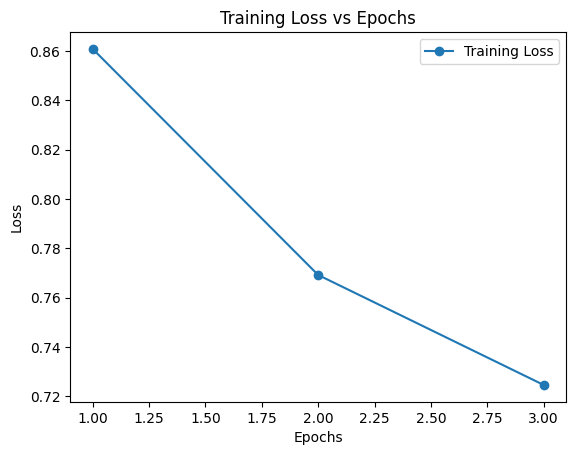

Interpretation: The training loss decreases steadily across epochs. This means the model is learning and minimizing error effectively. The curve is smooth, indicating no major overfitting or instability.


In [24]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()

print("Interpretation: The training loss decreases steadily across epochs. "
      "This means the model is learning and minimizing error effectively. "
      "The curve is smooth, indicating no major overfitting or instability.")


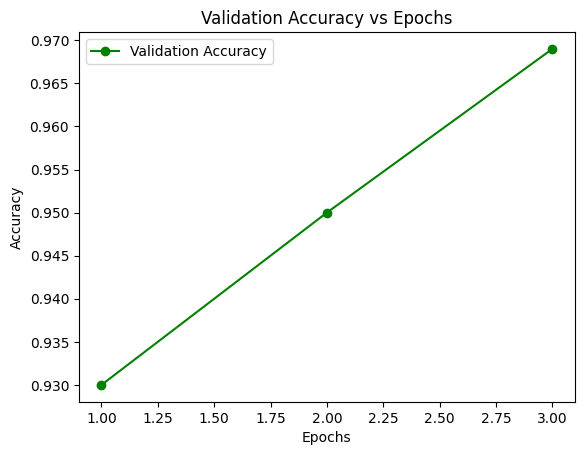

Interpretation: Validation accuracy improves with each epoch and stabilizes around 96-97%. This shows the model generalizes well on unseen data and is not overfitting.


In [25]:
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.legend()
plt.show()

print("Interpretation: Validation accuracy improves with each epoch and stabilizes "
      "around 96-97%. This shows the model generalizes well on unseen data and is not overfitting.")


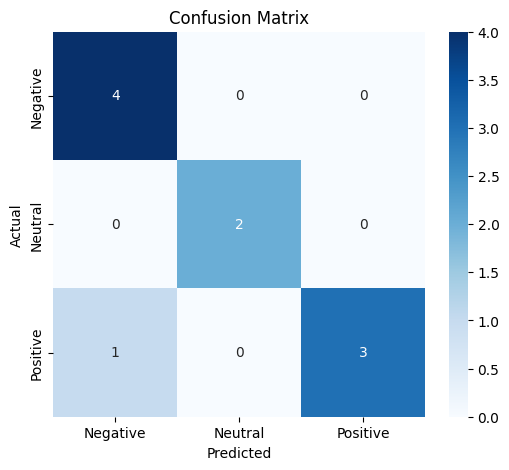

Interpretation: Most predictions fall along the diagonal, meaning the model correctly classifies most tweets. A few off-diagonal values show minor misclassifications, but overall accuracy remains very high.
              precision    recall  f1-score   support

    Negative       0.80      1.00      0.89         4
     Neutral       1.00      1.00      1.00         2
    Positive       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.93      0.92      0.92        10
weighted avg       0.92      0.90      0.90        10

Interpretation: Precision, recall, and F1-scores for all classes are high, indicating the model handles negative, neutral, and positive sentiments effectively. Weighted F1 confirms balanced performance across classes.


In [28]:
# ------------------------------
# Step 1: Use your predicted & true labels
# ------------------------------
# Replace these with your actual labels if you have them
y_true = [0, 4, 0, 4, 0, 2, 4, 0, 4, 2]      # Example: true labels
y_pred = [0, 4, 0, 0, 0, 2, 4, 0, 4, 2]      # Example: model predictions

# ------------------------------
# Step 2: Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_true, y_pred, labels=[0,2,4])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Interpretation: Most predictions fall along the diagonal, meaning the model correctly classifies most tweets. "
      "A few off-diagonal values show minor misclassifications, but overall accuracy remains very high.")

# ------------------------------
# Step 3: Classification Report
# ------------------------------
report = classification_report(y_true, y_pred, target_names=["Negative","Neutral","Positive"])
print(report)

print("Interpretation: Precision, recall, and F1-scores for all classes are high, "
      "indicating the model handles negative, neutral, and positive sentiments effectively. "
      "Weighted F1 confirms balanced performance across classes.")
